In [2]:
import math
import xarray as xr
import cartopy.crs as crs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import numpy as np
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import datetime as dt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from netCDF4 import date2num,num2date
import wrf
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords
from wrf import getvar, xy, interp2dxy
from wrf import to_np, getvar, CoordPair, vertcross
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)

In [3]:
#CURRENT DATA
cur_wrfout6 = Dataset('CUR_wrfout_d03_2018-03-25_06_00_00')
cur_wrfout10 = Dataset('CUR_wrfout_d03_2018-03-25_10_00_00')
cur_wrfout11= Dataset('CUR_wrfout_d03_2018-03-25_11_00_00')
cur_wrfout12 = Dataset('CUR_wrfout_d03_2018-03-25_12_00_00')
cur_wrfout13= Dataset('CUR_wrfout_d03_2018-03-25_13_00_00')

#SST DATA
sst_wrfout6 = Dataset('SST_wrfout_d03_2018-03-25_06_00_00')
sst_wrfout10 = Dataset('SST_wrfout_d03_2018-03-25_10_00_00')
sst_wrfout11 = Dataset('SST_wrfout_d03_2018-03-25_11_00_00')
sst_wrfout12 = Dataset('SST_wrfout_d03_2018-03-25_12_00_00')
sst_wrfout13 = Dataset('SST_wrfout_d03_2018-03-25_13_00_00')


In [11]:
#print(sst_wrfout10.variables)

In [4]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)
#print(cur_wrfout6.variables)
#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [5]:
#Get PBLH
#Not staggered
cur_pblh_10 = getvar(cur_wrfout10, "PBLH")
cur_pblh_11 = getvar(cur_wrfout11, "PBLH")
cur_pblh_12 = getvar(cur_wrfout12, "PBLH")
cur_pblh_13 = getvar(cur_wrfout13, "PBLH")

sst_pblh_10 = getvar(sst_wrfout10, "PBLH")
sst_pblh_11 = getvar(sst_wrfout11, "PBLH")
sst_pblh_12 = getvar(sst_wrfout12, "PBLH")
sst_pblh_13 = getvar(sst_wrfout13, "PBLH")

#Get Vert. Velocity W. 
cur_w_10 = getvar(cur_wrfout10, "W")
cur_w_11 = getvar(cur_wrfout11, "W")
cur_w_12 = getvar(cur_wrfout12, "W")
cur_w_13 = getvar(cur_wrfout13, "W")
#cur_w_10 = wrf.destagger(cur_w_10, stagger_dim = 0)
#cur_w_11  = wrf.destagger(cur_w_11, stagger_dim = 0)
#cur_w_12 = wrf.destagger(cur_w_12, stagger_dim = 0)
#cur_w_13  = wrf.destagger(cur_w_13, stagger_dim = 0)
print(cur_w_10.shape)

sst_w_10 = getvar(sst_wrfout10, "W")
sst_w_11 = getvar(sst_wrfout11, "W")
sst_w_12 = getvar(sst_wrfout12, "W")
sst_w_13 = getvar(sst_wrfout13, "W")
#sst_w_10 = wrf.destagger(sst_w_10, stagger_dim = 0)
#sst_w_11  = wrf.destagger(sst_w_11, stagger_dim = 0)
#sst_w_12 = wrf.destagger(sst_w_12, stagger_dim = 0)
#sst_w_13  = wrf.destagger(sst_w_13, stagger_dim = 0)

#Get U
cur_U_10 = getvar(cur_wrfout10, "U")
cur_U_11 = getvar(cur_wrfout11, "U")
cur_U_12 = getvar(cur_wrfout12, "U")
cur_U_13 = getvar(cur_wrfout13, "U")
#cur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)
#cur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)
#cur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)
#cur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)

cur_U10_10 = getvar(cur_wrfout10, "U10")
cur_U10_11 = getvar(cur_wrfout11, "U10")
cur_U10_12 = getvar(cur_wrfout12, "U10")
cur_U10_13 = getvar(cur_wrfout13, "U10")

sst_U_10 = getvar(sst_wrfout10, "U")
sst_U_11 = getvar(sst_wrfout11, "U")
sst_U_12 = getvar(sst_wrfout12, "U")
sst_U_13 = getvar(sst_wrfout13, "U")
#sst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)
#sst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)
#sst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)
#sst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)

sst_U10_10 = getvar(sst_wrfout10, "U10")
sst_U10_11 = getvar(sst_wrfout11, "U10")
sst_U10_12 = getvar(sst_wrfout12, "U10")
sst_U10_13 = getvar(sst_wrfout13, "U10")

cur_V_10 = getvar(cur_wrfout10, "V")
cur_V_11 = getvar(cur_wrfout11, "V")
cur_V_12 = getvar(cur_wrfout12, "V")
cur_V_13 = getvar(cur_wrfout13, "V")
#cur_V_10 = wrf.destagger(cur_V_10, stagger_dim = 1)
#cur_V_11  = wrf.destagger(cur_V_11, stagger_dim = 1)
#cur_V_12 = wrf.destagger(cur_V_12, stagger_dim = 1)
#cur_V_13  = wrf.destagger(cur_V_13, stagger_dim = 1)

cur_V10_10 = getvar(cur_wrfout10, "V10")
cur_V10_11 = getvar(cur_wrfout11, "V10")
cur_V10_12 = getvar(cur_wrfout12, "V10")
cur_V10_13 = getvar(cur_wrfout13, "V10")

sst_V_10 = getvar(sst_wrfout10, "V")
sst_V_11 = getvar(sst_wrfout11, "V")
sst_V_12 = getvar(sst_wrfout12, "V")
sst_V_13 = getvar(sst_wrfout13, "V")
#sst_V_10 = wrf.destagger(sst_V_10, stagger_dim = 1)
#sst_V_11  = wrf.destagger(sst_V_11, stagger_dim = 1)
#sst_V_12 = wrf.destagger(sst_V_12, stagger_dim = 1)
#sst_V_13  = wrf.destagger(sst_V_13, stagger_dim = 1)

sst_V10_10 = getvar(sst_wrfout10, "V10")
sst_V10_11 = getvar(sst_wrfout11, "V10")
sst_V10_12 = getvar(sst_wrfout12, "V10")
sst_V10_13 = getvar(sst_wrfout13, "V10")


(100, 474, 639)


In [5]:
#AVG SFC VORT
cur_U10_N = np.mean( np.array([cur_U10_11, cur_U10_12, cur_U10_13]), axis=0 )
cur_V10_N = np.mean( np.array([cur_V10_11, cur_V10_12, cur_V10_13]), axis=0 )
sst_U10_N = np.mean( np.array([sst_U10_11, sst_U10_12, sst_U10_13]), axis=0 )
sst_V10_N = np.mean( np.array([sst_V10_11, sst_V10_12, sst_V10_13]), axis=0 )

cur_U10_S = np.mean( np.array([cur_U10_10, cur_U10_11, cur_U10_12]), axis=0 )
cur_V10_S = np.mean( np.array([cur_V10_10, cur_V10_11, cur_V10_12]), axis=0 )
sst_U10_S = np.mean( np.array([sst_U10_10, sst_U10_11, sst_U10_12]), axis=0 )
sst_V10_S = np.mean( np.array([sst_V10_10, sst_V10_11, sst_V10_12]), axis=0 )

#surface winds on subdomains
#CUR S U
south_cur_u10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U10_S[y][x])
    south_cur_u10.append(inner_arr_cur)
south_cur_u10 = np.array(south_cur_u10)
print('S', south_cur_u10.shape)

#CUR N U
north_cur_u10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U10_N[y][x])
    north_cur_u10.append(inner_arr_cur)
north_cur_u10 = np.array(north_cur_u10)
print('N', north_cur_u10.shape)

#SST S U
south_sst_u10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U10_S[y][x])
    south_sst_u10.append(inner_arr_sst)
south_sst_u10 = np.array(south_sst_u10)
print('S', south_sst_u10.shape)

#SST N U 
north_sst_u10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U10_N[y][x])
    north_sst_u10.append(inner_arr_sst)
north_sst_u10 = np.array(north_sst_u10)
print('N', north_sst_u10.shape)

#CUR S V
south_cur_v10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V10_S[y][x])
    south_cur_v10.append(inner_arr_cur)
south_cur_v10 = np.array(south_cur_v10)
print('S', south_cur_v10.shape)

#CUR N V
north_cur_v10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V10_N[y][x])
    north_cur_v10.append(inner_arr_cur)
north_cur_v10 = np.array(north_cur_v10)
print('N', north_cur_v10.shape)

#SST S V
south_sst_v10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V10_S[y][x])
    south_sst_v10.append(inner_arr_sst)
south_sst_v10 = np.array(south_sst_v10)
print('S', south_sst_v10.shape)

#SST N V 
north_sst_v10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V10_N[y][x])
    north_sst_v10.append(inner_arr_sst)
north_sst_v10 = np.array(north_sst_v10)
print('N', north_sst_v10.shape)

#surface winds vorticity
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

sst_curl10_N = mpcalc.vorticity(u=north_sst_u10*units('m/s'), v=north_sst_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl10_S = mpcalc.vorticity(u=south_sst_u10*units('m/s'), v=south_sst_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl10_N = mpcalc.vorticity(u=north_cur_u10*units('m/s'), v=north_cur_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl10_S = mpcalc.vorticity(u=south_cur_u10*units('m/s'), v=south_cur_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

N_sfc_diff = cur_curl10_N - sst_curl10_N
S_sfc_diff = cur_curl10_S - sst_curl10_S


S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)


In [7]:
#AVG PBLH VORT 
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl13.shape)

#get on PBLH
print(sst_U_10.shape)
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

cur_U_N = np.mean( np.array([cur_uwind11_pblh, cur_uwind12_pblh, cur_uwind13_pblh]), axis=0 )
cur_V_N = np.mean( np.array([cur_vwind11_pblh, cur_vwind12_pblh, cur_vwind13_pblh]), axis=0 )
sst_U_N = np.mean( np.array([sst_uwind11_pblh, sst_uwind12_pblh, sst_uwind13_pblh]), axis=0 )
sst_V_N = np.mean( np.array([sst_vwind11_pblh, sst_vwind12_pblh, sst_vwind13_pblh]), axis=0 )

cur_U_S = np.mean( np.array([cur_uwind10_pblh, cur_uwind11_pblh, cur_uwind12_pblh]), axis=0 )
cur_V_S = np.mean( np.array([cur_vwind10_pblh, cur_vwind11_pblh, cur_vwind12_pblh]), axis=0 )
sst_U_S = np.mean( np.array([sst_uwind10_pblh, sst_uwind11_pblh, sst_uwind12_pblh]), axis=0 )
sst_V_S = np.mean( np.array([sst_vwind10_pblh, sst_vwind11_pblh, sst_vwind12_pblh]), axis=0 )

(99, 474, 639)
(474, 639)


In [8]:
#pblh winds on subdomains
#CUR S U
south_cur_u = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U_S[y][x])
    south_cur_u.append(inner_arr_cur)
south_cur_u = np.array(south_cur_u)
print(south_cur_u.shape)

#CUR N U
north_cur_u = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U_N[y][x])
    north_cur_u.append(inner_arr_cur)
north_cur_u = np.array(north_cur_u)

#SST S U
south_sst_u = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U_S[y][x])
    south_sst_u.append(inner_arr_sst)
south_sst_u = np.array(south_sst_u)

#SST N U 
north_sst_u = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U_N[y][x])
    north_sst_u.append(inner_arr_sst)
north_sst_u = np.array(north_sst_u)
print(north_sst_u.shape)

#CUR S V
south_cur_v = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V_S[y][x])
    south_cur_v.append(inner_arr_cur)
south_cur_v = np.array(south_cur_v)

#CUR N V
north_cur_v = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V_N[y][x])
    north_cur_v.append(inner_arr_cur)
north_cur_v = np.array(north_cur_v)

#SST S V
south_sst_v = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V_S[y][x])
    south_sst_v.append(inner_arr_sst)
south_sst_v = np.array(south_sst_v)

#SST N V 
north_sst_v = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V_N[y][x])
    north_sst_v.append(inner_arr_sst)
north_sst_v = np.array(north_sst_v)
print(north_sst_v.shape)

#pblh winds vorticity
sst_curl_N_pblh = mpcalc.vorticity(u=north_sst_u*units('m/s'), v=north_sst_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl_S_pblh = mpcalc.vorticity(u=south_sst_u*units('m/s'), v=south_sst_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl_N_pblh = mpcalc.vorticity(u=north_cur_u*units('m/s'), v=north_cur_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl_S_pblh = mpcalc.vorticity(u=south_cur_u*units('m/s'), v=south_cur_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
      
N_pblh_diff = cur_curl_N_pblh - sst_curl_N_pblh
S_pblh_diff = cur_curl_S_pblh - sst_curl_S_pblh


(67, 118)
(67, 167)
(67, 167)


In [6]:
#geopotential height above ground level
#wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#height_agl6 = wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl13.shape)
print('\n', sst_w_10.shape)

agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)

 (99, 474, 639)


In [8]:
#get w at PBLH
sst_w10_pblh = interplevel(sst_w_10, sst_height_agl10, sst_pblh_10)
sst_w11_pblh = interplevel(sst_w_11, sst_height_agl11, sst_pblh_11)
sst_w12_pblh = interplevel(sst_w_12, sst_height_agl12, sst_pblh_12)
sst_w13_pblh = interplevel(sst_w_13, sst_height_agl13, sst_pblh_13)

cur_w10_pblh = interplevel(cur_w_10, cur_height_agl10, cur_pblh_10)
cur_w11_pblh = interplevel(cur_w_11, cur_height_agl11, cur_pblh_11)
cur_w12_pblh = interplevel(cur_w_12, cur_height_agl12, cur_pblh_12)
cur_w13_pblh = interplevel(cur_w_13, cur_height_agl13, cur_pblh_13)

sst_w10_pblh = interplevel(sst_w_10, sst_height_agl10, sst_pblh_10)
sst_w11_pblh = interplevel(sst_w_11, sst_height_agl11, sst_pblh_11)
sst_w12_pblh = interplevel(sst_w_12, sst_height_agl12, sst_pblh_12)
sst_w13_pblh = interplevel(sst_w_13, sst_height_agl13, sst_pblh_13)

cur_w10_pblh = interplevel(cur_w_10, cur_height_agl10, cur_pblh_10)
cur_w11_pblh = interplevel(cur_w_11, cur_height_agl11, cur_pblh_11)
cur_w12_pblh = interplevel(cur_w_12, cur_height_agl12, cur_pblh_12)
cur_w13_pblh = interplevel(cur_w_13, cur_height_agl13, cur_pblh_13)
print(cur_w10_pblh.shape)

(474, 639)


In [9]:
#SST reshape 
sst_w10_pblh_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_w10_pblh[y][x])
    sst_w10_pblh_south.append(inner_arr_sst10)
sst_w10_pblh_south = np.array(sst_w10_pblh_south)

sst_w10_pblh_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_w10_pblh[y][x])
    sst_w10_pblh_north.append(inner_arr_sst10)
sst_w10_pblh_north = np.array(sst_w10_pblh_north)

sst_w11_pblh_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_w11_pblh[y][x])
    sst_w11_pblh_south.append(inner_arr_sst11)
sst_w11_pblh_south = np.array(sst_w11_pblh_south)

sst_w11_pblh_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_w11_pblh[y][x])
    sst_w11_pblh_north.append(inner_arr_sst11)
sst_w11_pblh_north = np.array(sst_w11_pblh_north)

sst_w12_pblh_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_w12_pblh[y][x])
    sst_w12_pblh_south.append(inner_arr_sst12)
sst_w12_pblh_south = np.array(sst_w12_pblh_south)

sst_w12_pblh_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_w12_pblh[y][x])
    sst_w12_pblh_north.append(inner_arr_sst12)
sst_w12_pblh_north = np.array(sst_w12_pblh_north)

sst_w13_pblh_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_w13_pblh[y][x])
    sst_w13_pblh_south.append(inner_arr_sst13)
sst_w13_pblh_south = np.array(sst_w13_pblh_south)

sst_w13_pblh_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_w13_pblh[y][x])
    sst_w13_pblh_north.append(inner_arr_sst13)
sst_w13_pblh_north = np.array(sst_w13_pblh_north)
print(sst_w13_pblh_north.shape)

#SST reshape 
sst_w10_pblh_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_w10_pblh[y][x])
    sst_w10_pblh_south.append(inner_arr_sst10)
sst_w10_pblh_south = np.array(sst_w10_pblh_south)

sst_w10_pblh_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_w10_pblh[y][x])
    sst_w10_pblh_north.append(inner_arr_sst10)
sst_w10_pblh_north = np.array(sst_w10_pblh_north)

sst_w11_pblh_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_w11_pblh[y][x])
    sst_w11_pblh_south.append(inner_arr_sst11)
sst_w11_pblh_south = np.array(sst_w11_pblh_south)

sst_w11_pblh_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_w11_pblh[y][x])
    sst_w11_pblh_north.append(inner_arr_sst11)
sst_w11_pblh_north = np.array(sst_w11_pblh_north)

sst_w12_pblh_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_w12_pblh[y][x])
    sst_w12_pblh_south.append(inner_arr_sst12)
sst_w12_pblh_south = np.array(sst_w12_pblh_south)

sst_w12_pblh_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_w12_pblh[y][x])
    sst_w12_pblh_north.append(inner_arr_sst12)
sst_w2_pblh_north = np.array(sst_w12_pblh_north)

sst_w13_pblh_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_w13_pblh[y][x])
    sst_w13_pblh_south.append(inner_arr_sst13)
sst_w13_pblh_south = np.array(sst_w13_pblh_south)

sst_w13_pblh_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_w13_pblh[y][x])
    sst_w13_pblh_north.append(inner_arr_sst13)
sst_w13_pblh_north = np.array(sst_w13_pblh_north)
print(sst_w13_pblh_north.shape)

#CUR reshape 
cur_w10_pblh_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_w10_pblh[y][x])
    cur_w10_pblh_south.append(inner_arr_cur10)
cur_w10_pblh_south = np.array(cur_w10_pblh_south)

cur_w10_pblh_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_w10_pblh[y][x])
    cur_w10_pblh_north.append(inner_arr_cur10)
cur_w10_pblh_north = np.array(cur_w10_pblh_north)

cur_w11_pblh_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_w11_pblh[y][x])
    cur_w11_pblh_south.append(inner_arr_cur11)
cur_w11_pblh_south = np.array(cur_w11_pblh_south)

cur_w11_pblh_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_w11_pblh[y][x])
    cur_w11_pblh_north.append(inner_arr_cur11)
cur_w11_pblh_north = np.array(cur_w11_pblh_north)

cur_w12_pblh_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_w12_pblh[y][x])
    cur_w12_pblh_south.append(inner_arr_cur12)
cur_w12_pblh_south = np.array(cur_w12_pblh_south)

cur_w12_pblh_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_w12_pblh[y][x])
    cur_w12_pblh_north.append(inner_arr_cur12)
cur_w_pblh_north = np.array(cur_w12_pblh_north)

cur_w13_pblh_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_w13_pblh[y][x])
    cur_w13_pblh_south.append(inner_arr_cur13)
cur_w13_pblh_south = np.array(cur_w13_pblh_south)

cur_w13_pblh_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_w13_pblh[y][x])
    cur_w13_pblh_north.append(inner_arr_cur13)
cur_w13_pblh_north = np.array(cur_w13_pblh_north)
print(cur_w13_pblh_north.shape)

#CUR reshape 
cur_w10_pblh_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_w10_pblh[y][x])
    cur_w10_pblh_south.append(inner_arr_cur10)
cur_w10_pblh_south = np.array(cur_w10_pblh_south)

cur_w10_pblh_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_w10_pblh[y][x])
    cur_w10_pblh_north.append(inner_arr_cur10)
cur_w10_pblh_north = np.array(cur_w10_pblh_north)

cur_w11_pblh_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_w11_pblh[y][x])
    cur_w11_pblh_south.append(inner_arr_cur11)
cur_w11_pblh_south = np.array(cur_w11_pblh_south)

cur_w11_pblh_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_w11_pblh[y][x])
    cur_w11_pblh_north.append(inner_arr_cur11)
cur_w11_pblh_north = np.array(cur_w11_pblh_north)

cur_w12_pblh_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_w12_pblh[y][x])
    cur_w12_pblh_south.append(inner_arr_cur12)
cur_w12_pblh_south = np.array(cur_w12_pblh_south)

cur_w12_pblh_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_w12_pblh[y][x])
    cur_w12_pblh_north.append(inner_arr_cur12)
cur_w12_pblh_north = np.array(cur_w12_pblh_north)

cur_w13_pblh_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_w13_pblh[y][x])
    cur_w13_pblh_south.append(inner_arr_cur13)
cur_w13_pblh_south = np.array(cur_w13_pblh_south)

cur_w13_pblh_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_w13_pblh[y][x])
    cur_w13_pblh_north.append(inner_arr_cur13)
cur_w13_pblh_north = np.array(cur_w13_pblh_north)
print(cur_w13_pblh_north.shape)


(67, 167)
(67, 167)
(67, 167)
(67, 167)


In [11]:
#AVG
sst_north_avg_w = np.mean( np.array([sst_w11_pblh_north ,sst_w12_pblh_north, sst_w13_pblh_north]), axis=0 )
sst_south_avg_w = np.mean( np.array([sst_w10_pblh_south ,sst_w11_pblh_south, sst_w12_pblh_south]), axis=0 )
cur_north_avg_w = np.mean( np.array([cur_w11_pblh_north ,cur_w12_pblh_north, cur_w13_pblh_north]), axis=0 )
cur_south_avg_w = np.mean( np.array([cur_w10_pblh_south ,cur_w11_pblh_south, cur_w12_pblh_south]), axis=0 )

N_diff = cur_north_avg_w - sst_north_avg_w 
S_diff = cur_south_avg_w - sst_south_avg_w 

print('SST N ')
print(np.max(sst_north_avg_w))
print(np.min(sst_north_avg_w))
print('CUR N ')
print(np.nanmax(cur_north_avg_w))
print(np.nanmin(cur_north_avg_w))
print('SST S')
print(np.max(sst_south_avg_w))
print(np.min(sst_south_avg_w))
print('CUR S')
print(np.max(cur_south_avg_w))
print(np.min(cur_south_avg_w))
print('Diff N ')
print(np.nanmax(N_diff ))
print(np.nanmin(N_diff ))
print('Diff S')
print(np.max(S_diff ))
print(np.min(S_diff ))

SST N 
0.35897532
-0.24868113
CUR N 
0.3754654
-0.2129661
SST S
0.008944136
-0.014359393
CUR S
0.010074075
-0.018776832
Diff N 
0.42865136
-0.34728086
Diff S
0.015108614
-0.01591689


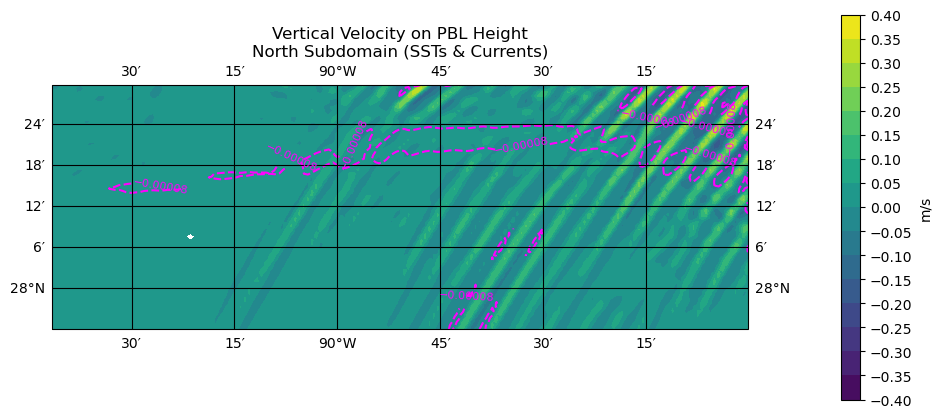

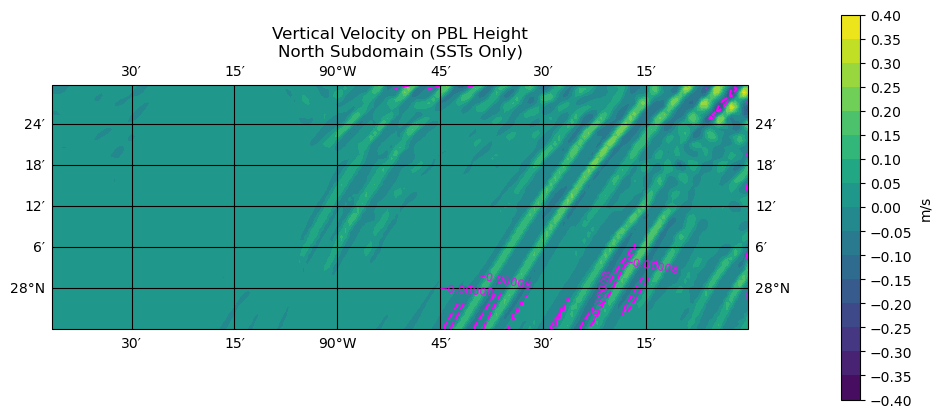

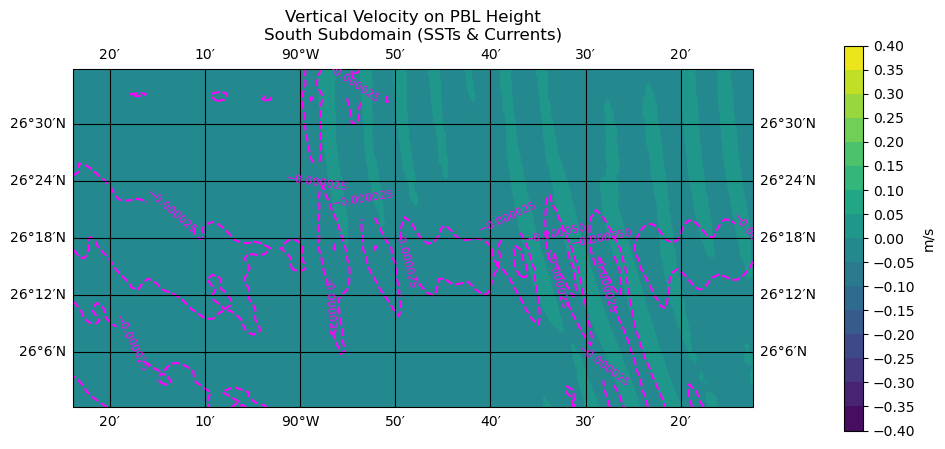

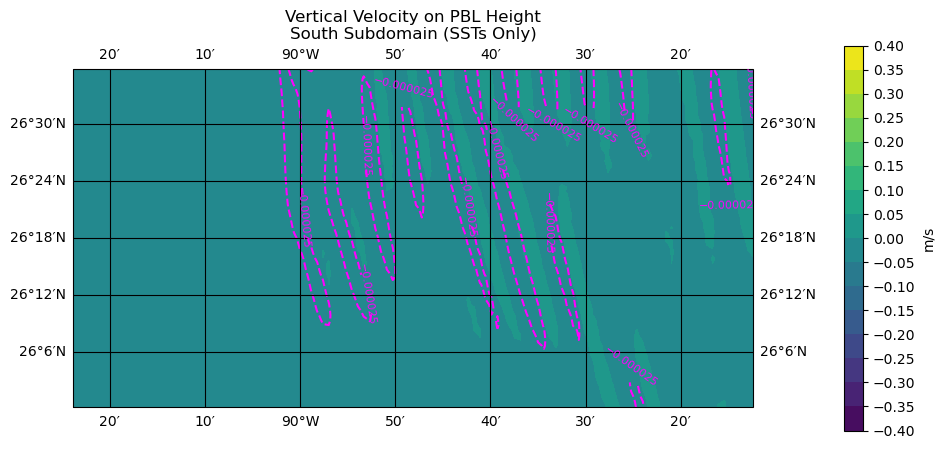

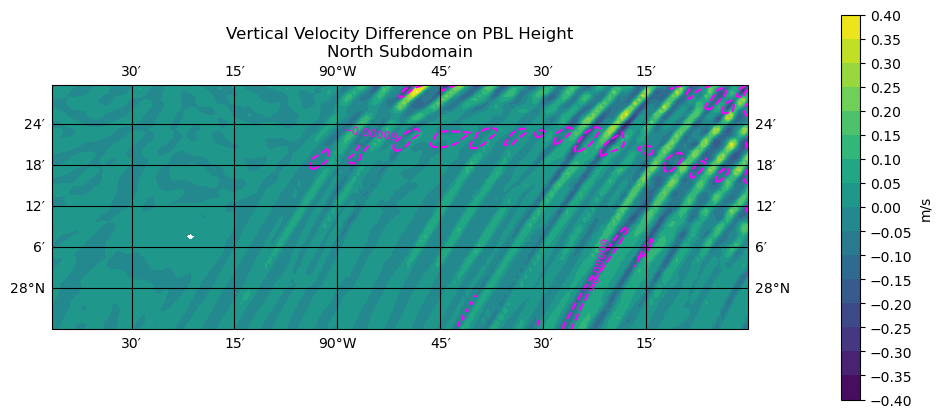

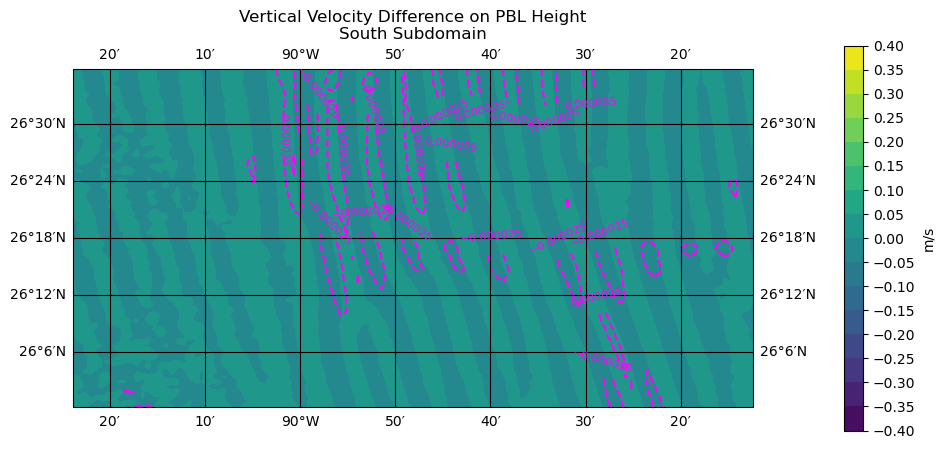

In [12]:
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]
#vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]
vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]


#PLOT w at PBLH 
bounds = [-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

#North CUR 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_w, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity on PBL Height\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_w, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity on PBL Height\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH CUR 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_w, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity on PBL Height\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_w, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity on PBL Height\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#North Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_diff, levels = bounds)
#s = ax.contourf(north_lon, north_lat, N_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
#lt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity Difference on PBL Height\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#South Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
#s = ax.contourf(south_lon, south_lat, S_diff)
cs = ax.contourf(south_lon, south_lat, S_diff, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
#lt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity Difference on PBL Height\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [13]:
#get w at PBLH+500
sst_w10_free = interplevel(sst_w_10, sst_height_agl10, sst_pblh_10+500)
sst_w11_free = interplevel(sst_w_11, sst_height_agl11, sst_pblh_11+500)
sst_w12_free = interplevel(sst_w_12, sst_height_agl12, sst_pblh_12+500)
sst_w13_free = interplevel(sst_w_13, sst_height_agl13, sst_pblh_13+500)

cur_w10_free = interplevel(cur_w_10, cur_height_agl10, cur_pblh_10+500)
cur_w11_free = interplevel(cur_w_11, cur_height_agl11, cur_pblh_11+500)
cur_w12_free = interplevel(cur_w_12, cur_height_agl12, cur_pblh_12+500)
cur_w13_free = interplevel(cur_w_13, cur_height_agl13, cur_pblh_13+500)

sst_w10_free = interplevel(sst_w_10, sst_height_agl10, sst_pblh_10+500)
sst_w11_free = interplevel(sst_w_11, sst_height_agl11, sst_pblh_11+500)
sst_w12_free = interplevel(sst_w_12, sst_height_agl12, sst_pblh_12+500)
sst_w13_free = interplevel(sst_w_13, sst_height_agl13, sst_pblh_13+500)

cur_w10_free = interplevel(cur_w_10, cur_height_agl10, cur_pblh_10+500)
cur_w11_free = interplevel(cur_w_11, cur_height_agl11, cur_pblh_11+500)
cur_w12_free = interplevel(cur_w_12, cur_height_agl12, cur_pblh_12+500)
cur_w13_free = interplevel(cur_w_13, cur_height_agl13, cur_pblh_13+500)
print(cur_w10_free.shape)

(474, 639)


In [5]:
#SST reshape 
sst_w10_free_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_w10_free[y][x])
    sst_w10_free_south.append(inner_arr_sst10)
sst_w10_free_south = np.array(sst_w10_free_south)

sst_w10_free_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_w10_free[y][x])
    sst_w10_free_north.append(inner_arr_sst10)
sst_w10_free_north = np.array(sst_w10_free_north)

sst_w11_free_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_w11_free[y][x])
    sst_w11_free_south.append(inner_arr_sst11)
sst_w11_free_south = np.array(sst_w11_free_south)

sst_w11_free_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_w11_free[y][x])
    sst_w11_free_north.append(inner_arr_sst11)
sst_w11_free_north = np.array(sst_w11_free_north)

sst_w12_free_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_w12_free[y][x])
    sst_w12_free_south.append(inner_arr_sst12)
sst_w12_free_south = np.array(sst_w12_free_south)

sst_w12_free_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_w12_free[y][x])
    sst_w12_free_north.append(inner_arr_sst12)
sst_w12_free_north = np.array(sst_w12_free_north)

sst_w13_free_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_w13_free[y][x])
    sst_w13_free_south.append(inner_arr_sst13)
sst_w13_free_south = np.array(sst_w13_free_south)

sst_w13_free_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_w13_free[y][x])
    sst_w13_free_north.append(inner_arr_sst13)
sst_w13_free_north = np.array(sst_w13_free_north)
print(sst_w13_free_north.shape)

#CUR reshape 
cur_w10_free_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_w10_free[y][x])
    cur_w10_free_south.append(inner_arr_cur10)
cur_w10_free_south = np.array(cur_w10_free_south)

cur_w10_free_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_w10_free[y][x])
    cur_w10_free_north.append(inner_arr_cur10)
cur_w10_free_north = np.array(cur_w10_free_north)

cur_w11_free_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_w11_free[y][x])
    cur_w11_free_south.append(inner_arr_cur11)
cur_w11_free_south = np.array(cur_w11_free_south)

cur_w11_free_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_w11_free[y][x])
    cur_w11_free_north.append(inner_arr_cur11)
cur_w11_free_north = np.array(cur_w11_free_north)

cur_w12_free_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_w12_free[y][x])
    cur_w12_free_south.append(inner_arr_cur12)
cur_w12_free_south = np.array(cur_w12_free_south)

cur_w12_free_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_w12_free[y][x])
    cur_w12_free_north.append(inner_arr_cur12)
cur_w_free_north = np.array(cur_w12_free_north)

cur_w13_free_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_w13_free[y][x])
    cur_w13_free_south.append(inner_arr_cur13)
cur_w13_free_south = np.array(cur_w13_free_south)

cur_w13_free_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_w13_free[y][x])
    cur_w13_free_north.append(inner_arr_cur13)
cur_w13_free_north = np.array(cur_w13_free_north)
print(cur_w13_free_north.shape)

NameError: name 'sst_w10_free' is not defined

In [16]:
#AVG
sst_north_avg_w_free = np.mean( np.array([sst_w11_free_north ,sst_w12_pblh_north, sst_w13_free_north]), axis=0 )
sst_south_avg_w_free = np.mean( np.array([sst_w10_free_south ,sst_w11_pblh_south, sst_w12_free_south]), axis=0 )
cur_north_avg_w_free = np.mean( np.array([cur_w11_free_north ,cur_w12_pblh_north, cur_w13_free_north]), axis=0 )
cur_south_avg_w_free = np.mean( np.array([cur_w10_free_south ,cur_w11_pblh_south, cur_w12_free_south]), axis=0 )

N_diff = cur_north_avg_w_free - sst_north_avg_w_free 
S_diff = cur_south_avg_w_free - sst_south_avg_w_free 

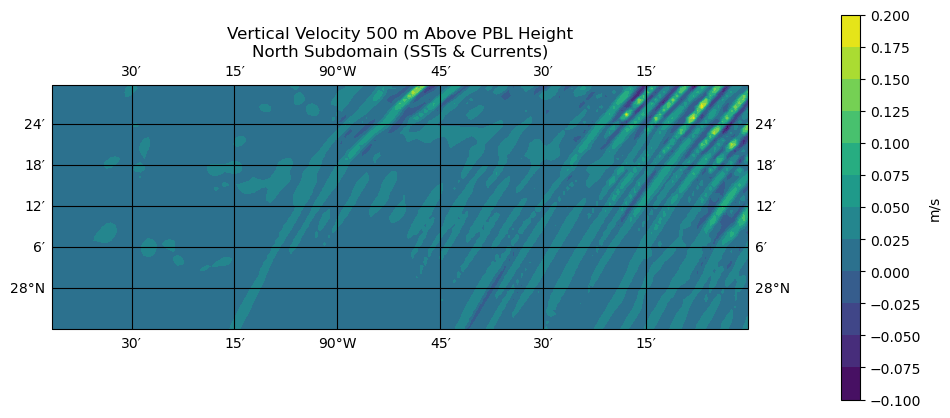

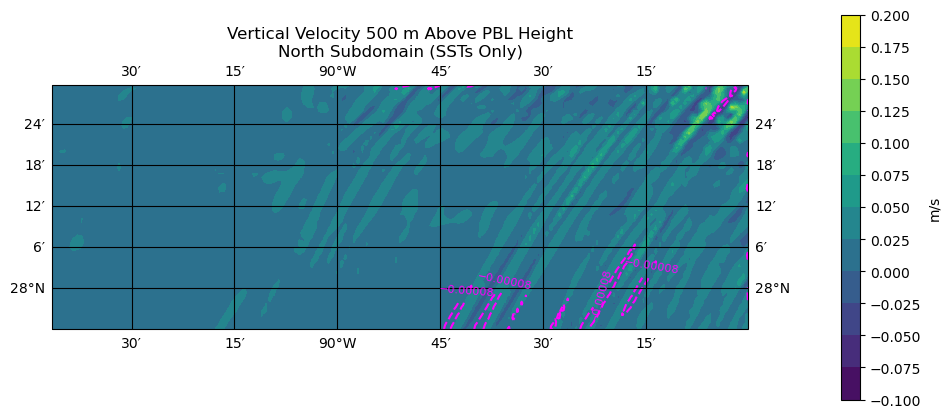

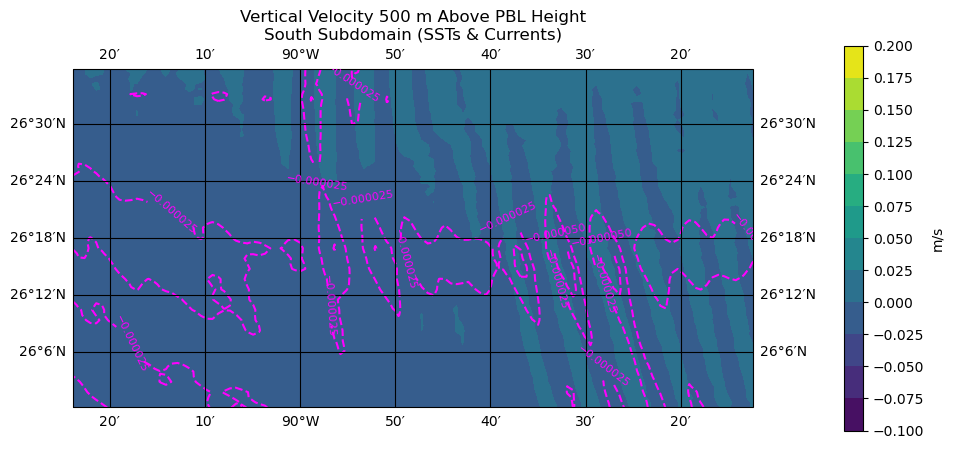

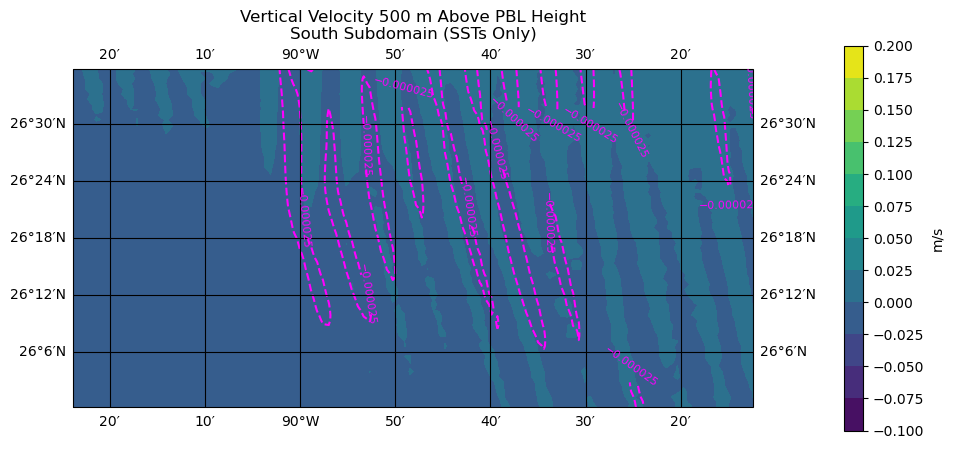

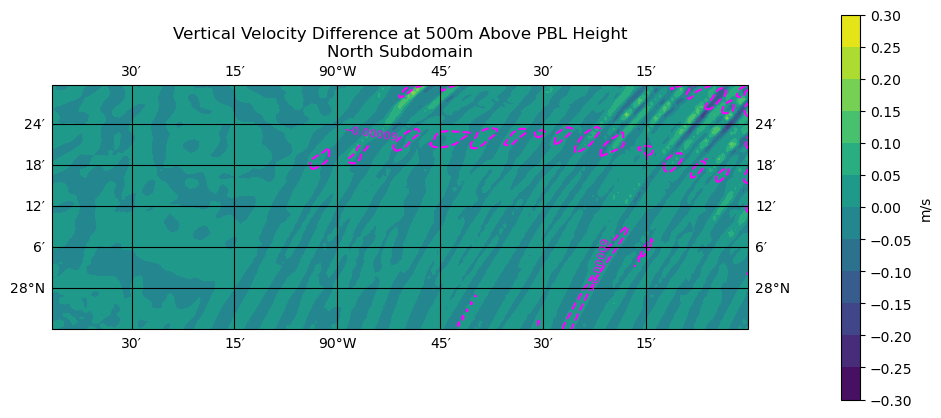

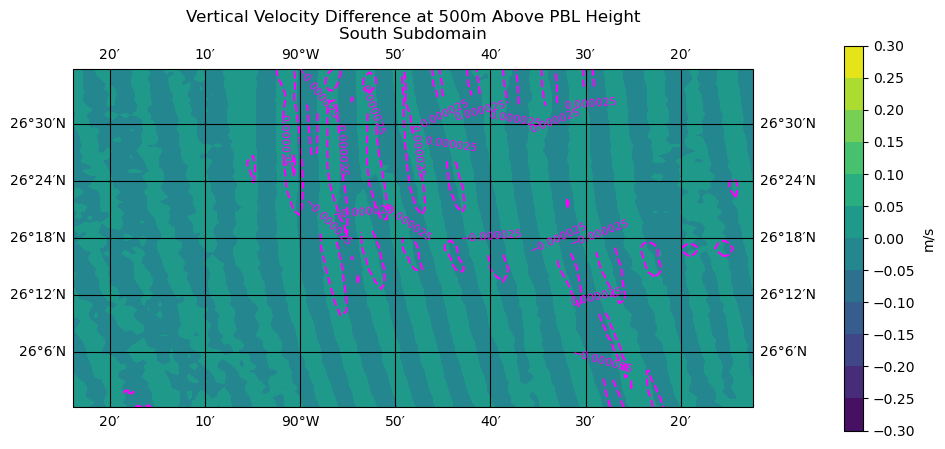

In [17]:
#PLOT w at free

#PLOT w at PBLH 
#NORTH CUR 
bounds = [ -0.10, -0.075, -0.050, -0.025, 0, 0.025, 0.050, 0.075, 0.10, 0.125, 0.15, 0.175, 0.2]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_w_free, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity 500 m Above PBL Height\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_w_free, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity 500 m Above PBL Height\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH CUR
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_w_free, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity 500 m Above PBL Height\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_w_free, levels = bounds)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity 500 m Above PBL Height\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


bounds = [-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#North Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_diff, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, N_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity Difference at 500m Above PBL Height\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_w@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#South Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
#cs = ax.contourf(south_lon, south_lat, S_diff)
cs = ax.contourf(south_lon, south_lat, S_diff, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1,  label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Vertical Velocity Difference at 500m Above PBL Height\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_w@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [6]:
sst_w_north = (sst_w_11 + sst_w_12 + sst_w_13) /3
sst_w_south = (sst_w_10 + sst_w_11 + sst_w_12) /3
cur_w_north = (cur_w_11 + cur_w_12 + cur_w_13) /3
cur_w_south = (cur_w_10 + cur_w_11 + cur_w_12) /3

N_diff = cur_w_north -sst_w_north 
S_diff = cur_w_south -sst_w_south 

cur_z10 = getvar(cur_wrfout10, "z")
cur_z11 = getvar(cur_wrfout11, "z")
cur_z12 = getvar(cur_wrfout12, "z")
cur_z13 = getvar(cur_wrfout13, "z")

sst_z10 = getvar(sst_wrfout10, "z")
sst_z11 = getvar(sst_wrfout11, "z")
sst_z12 = getvar(sst_wrfout12, "z")
sst_z13 = getvar(sst_wrfout13, "z")

z_sst_south = (sst_z10 + sst_z11 +sst_z12)/3
z_cur_south = (cur_z10 + cur_z11 +cur_z12)/3
z_sst_north = (sst_z11 + sst_z12 +sst_z13)/3
z_cur_north = (cur_z11 + sst_z12 +sst_z13)/3

N_cur_pblh = (cur_pblh_11 + cur_pblh_12 +cur_pblh_13) /3
N_sst_pblh = (sst_pblh_11 + sst_pblh_12 +sst_pblh_13) /3
S_cur_pblh = (cur_pblh_10 + cur_pblh_11 +cur_pblh_12) /3
S_sst_pblh = (sst_pblh_10 + sst_pblh_11 +sst_pblh_12) /3


In [7]:
print('w shape old: ')
print(sst_w_north.shape)
print(sst_w_south.shape)
print(cur_w_north.shape)
print(cur_w_south.shape)

#print('w shape: ', w.shape)
#w = w[0:99, :, :]
#print('new w shape: ', w.shape)
sst_w_north = sst_w_north[0:99,:,:]
sst_w_south = sst_w_south[0:99,:,:]
cur_w_north = cur_w_north[0:99,:,:]
cur_w_south = cur_w_south[0:99,:,:]

N_w_diff = cur_w_north - sst_w_north
S_w_diff = cur_w_south - sst_w_south
print('\nw shape new: ')
print(sst_w_north.shape)
print(sst_w_south.shape)
print(cur_w_north.shape)
print(cur_w_south.shape)

print('\nz shape: ')
print(z_sst_south.shape)

'''
print('w shape: ', w.shape)
w = w[0:99, :, :]
print('new w shape: ', w.shape)
'''

N_pblh_line_sst = wrf.interpline(field2d = N_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.9, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_sst = wrf.interpline(field2d = S_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)
N_pblh_line_cur = wrf.interpline(field2d = N_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.9, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_cur = wrf.interpline(field2d = S_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)

#print(N_pblh_line_sst.shape)
#print(S_pblh_line_sst.shape)
#print(N_pblh_line_cur.shape)
#print(S_pblh_line_cur.shape)


w shape old: 
(100, 474, 639)
(100, 474, 639)
(100, 474, 639)
(100, 474, 639)

w shape new: 
(99, 474, 639)
(99, 474, 639)
(99, 474, 639)
(99, 474, 639)

z shape: 
(99, 474, 639)


In [7]:
n_N = 11189
n_S = 7906

sst_w_north_mean = np.nanmean(sst_w_north[0:20,:,:])
sst_w_south_mean = np.nanmean(sst_w_south[0:20,:,:])
cur_w_north_mean = np.nanmean(cur_w_north[0:20,:,:])
cur_w_south_mean = np.nanmean(cur_w_south[0:20,:,:])
print( ' ' )
print('sst_w_north_mean: ', sst_w_north_mean)
print('sst_w_south_mean: ', sst_w_south_mean)
print('cur_w_north_mean: ', cur_w_north_mean)
print('cur_w_south_mean: ', cur_w_south_mean)

sst_w_north_std = np.nanstd(sst_w_north[0:20,:,:])
sst_w_south_std = np.nanstd(sst_w_south[0:20,:,:])
cur_w_north_std = np.nanstd(cur_w_north[0:20,:,:])
cur_w_south_std = np.nanstd(cur_w_south[0:20,:,:])
print( ' ' )
print('sst_w_north_std: ', sst_w_north_std)
print('sst_w_south_std: ', sst_w_south_std)
print('cur_w_north_std: ', cur_w_north_std)
print('cur_w_south_std: ', cur_w_south_std)

N_diff_mean = cur_w_north_mean - sst_w_north_mean
S_diff_mean = cur_w_south_mean - sst_w_south_mean
print( ' ' )
print('N_diff_mean: ', N_diff_mean )
print('S_diff_mean: ', S_diff_mean )

N_diff_std = cur_w_north_std - sst_w_north_std
S_diff_std = cur_w_south_std - sst_w_south_std
print( ' ' )
print('N_diff_std: ', N_diff_std )
print('S_diff_std: ', S_diff_std )

sst_w_north_mean_uncer = sst_w_north_std /np.sqrt(n_N)
sst_w_south_mean_uncer = sst_w_south_std /np.sqrt(n_S)
cur_w_north_mean_uncer = cur_w_north_std /np.sqrt(n_N)
cur_w_south_mean_uncer = cur_w_south_std /np.sqrt(n_S)
print( ' ' )
print('sst_w_north_mean_uncer: ', sst_w_north_mean_uncer)
print('sst_w_south_mean_uncer: ', sst_w_south_mean_uncer)
print('cur_w_north_mean_uncer: ', cur_w_north_mean_uncer)
print('cur_w_south_mean_uncer: ', cur_w_south_mean_uncer)

N_diff_mean_uncer = np.sqrt( ((cur_w_north_std **2)/n_N) + ((sst_w_north_std **2)/n_N))
S_diff_mean_uncer = np.sqrt( ((cur_w_south_std **2)/n_S) + ((sst_w_south_std **2)/n_S))
print( ' ' )
print('N_diff_mean_uncer: ', N_diff_mean_uncer)
print('S_diff_mean_uncer: ', S_diff_mean_uncer)

 
sst_w_north_mean:  0.0052526165
sst_w_south_mean:  0.0040111565
cur_w_north_mean:  0.005288397
cur_w_south_mean:  0.0040190914
 
sst_w_north_std:  0.033387348
sst_w_south_std:  0.023865053
cur_w_north_std:  0.03156311
cur_w_south_std:  0.023940936
 
N_diff_mean:  3.5780482e-05
S_diff_mean:  7.934868e-06
 
N_diff_std:  -0.0018242374
S_diff_std:  7.58823e-05
 
sst_w_north_mean_uncer:  0.00031563582313877425
sst_w_south_mean_uncer:  0.00026840092363671476
cur_w_north_mean_uncer:  0.00029838992884490993
cur_w_south_mean_uncer:  0.0002692543421997359
 
N_diff_mean_uncer:  0.00043435299294993
S_diff_mean_uncer:  0.00038018016334687176


In [11]:
#print(np.max(cur_w_north)) #1.01744378
#print(np.max(cur_w_south)) #0.79012769
#print(np.max(sst_w_north)) #0.87991983
#print(np.max(sst_w_south)) #0.77266341
#print('MIN: ')
#print(np.min(cur_w_north)) #-0.5588308
#print(np.min(cur_w_south)) #-0.66835099
#print(np.min(sst_w_north)) #-0.5839861
#print(np.min(sst_w_south)) #-0.56335217
#print('DIFF: ')
#print(np.max(N_w_diff)) #1.17449868
#print(np.max(S_w_diff)) #1.01708651
#print('MIN: ')
#print(np.min(N_w_diff)) #-1.28258538
#print(np.min(S_w_diff)) #-0.99430031



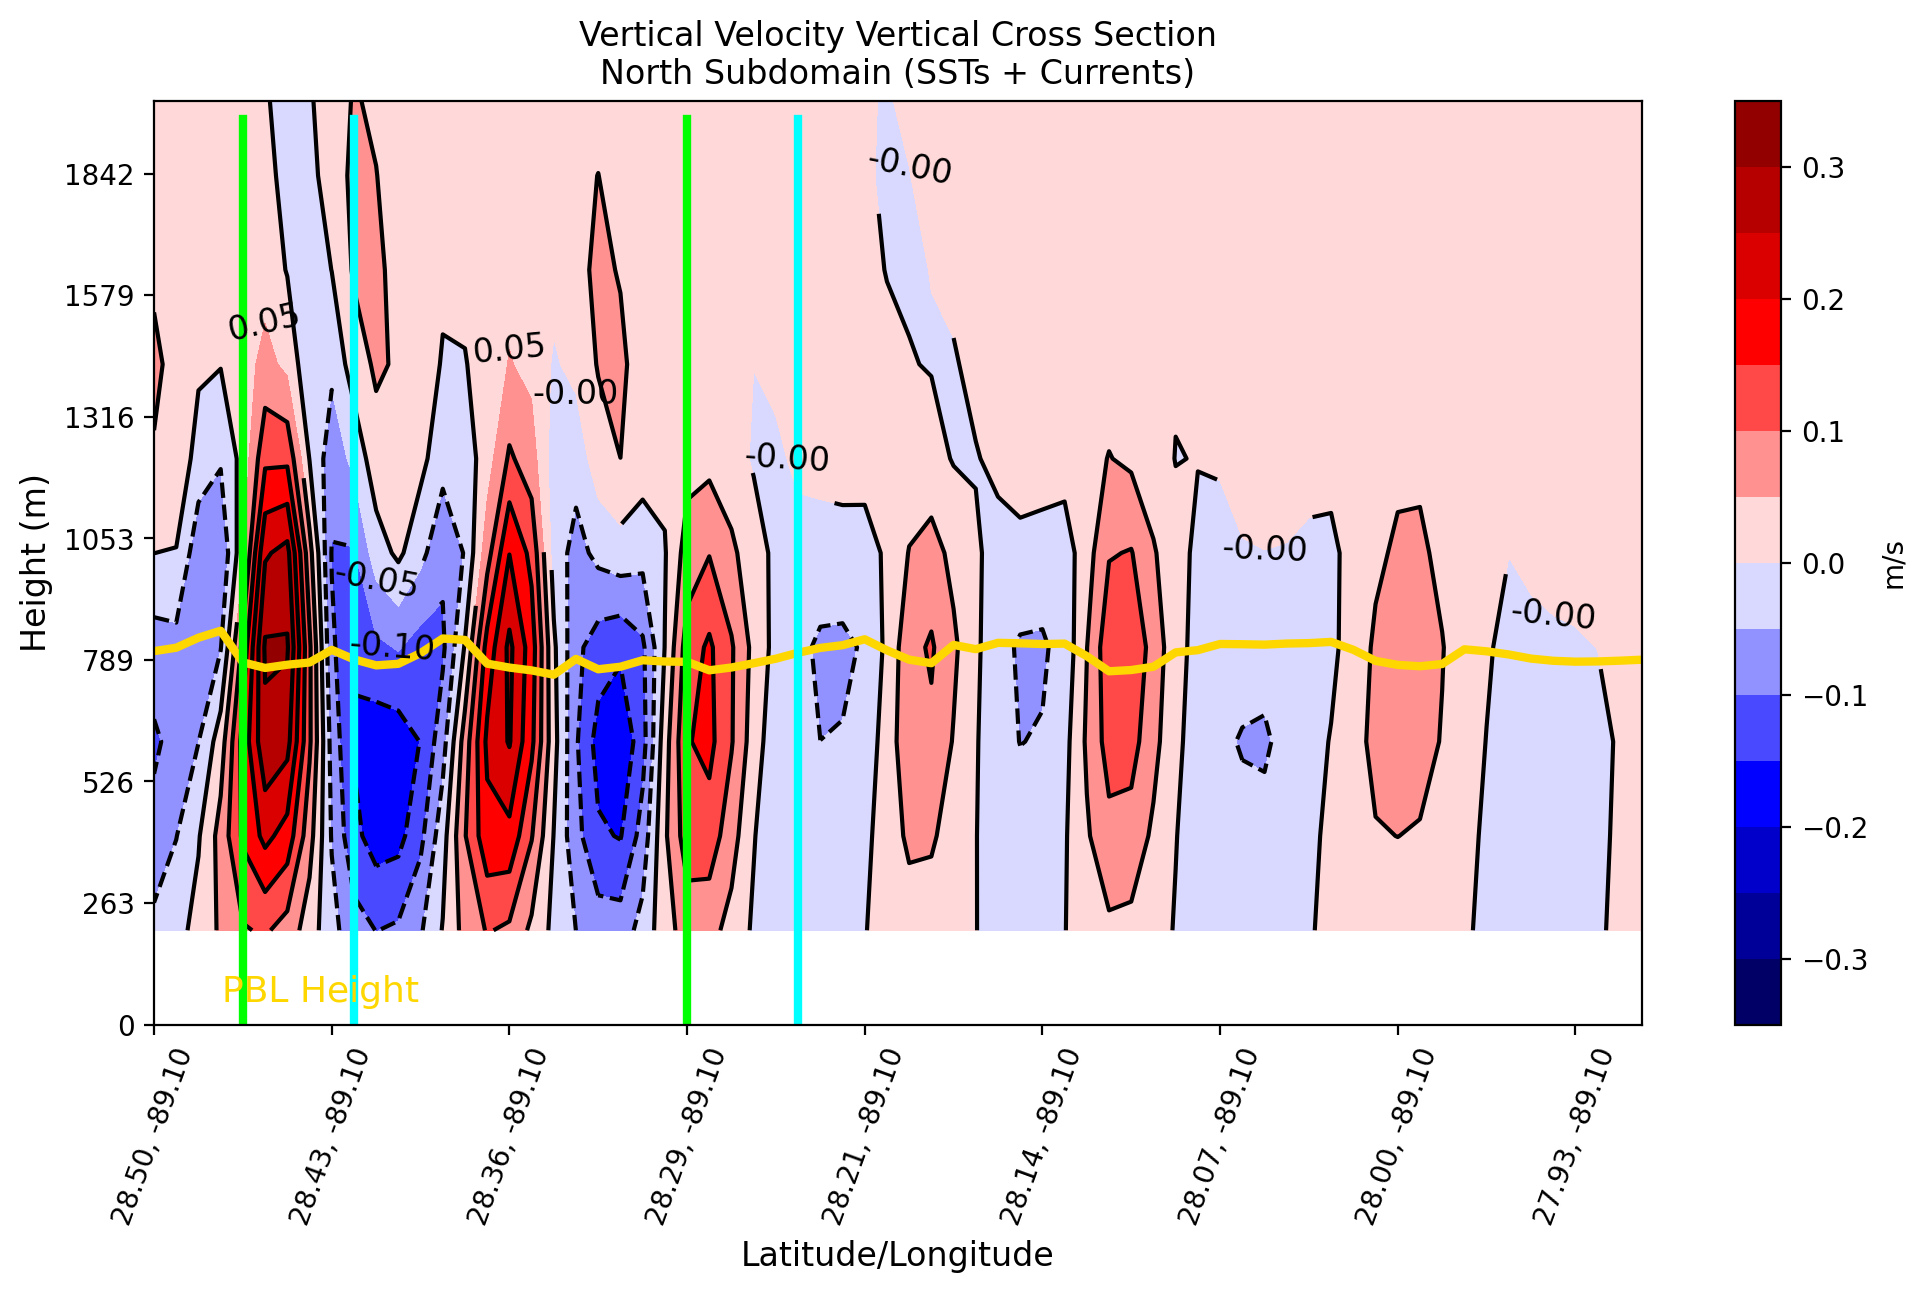

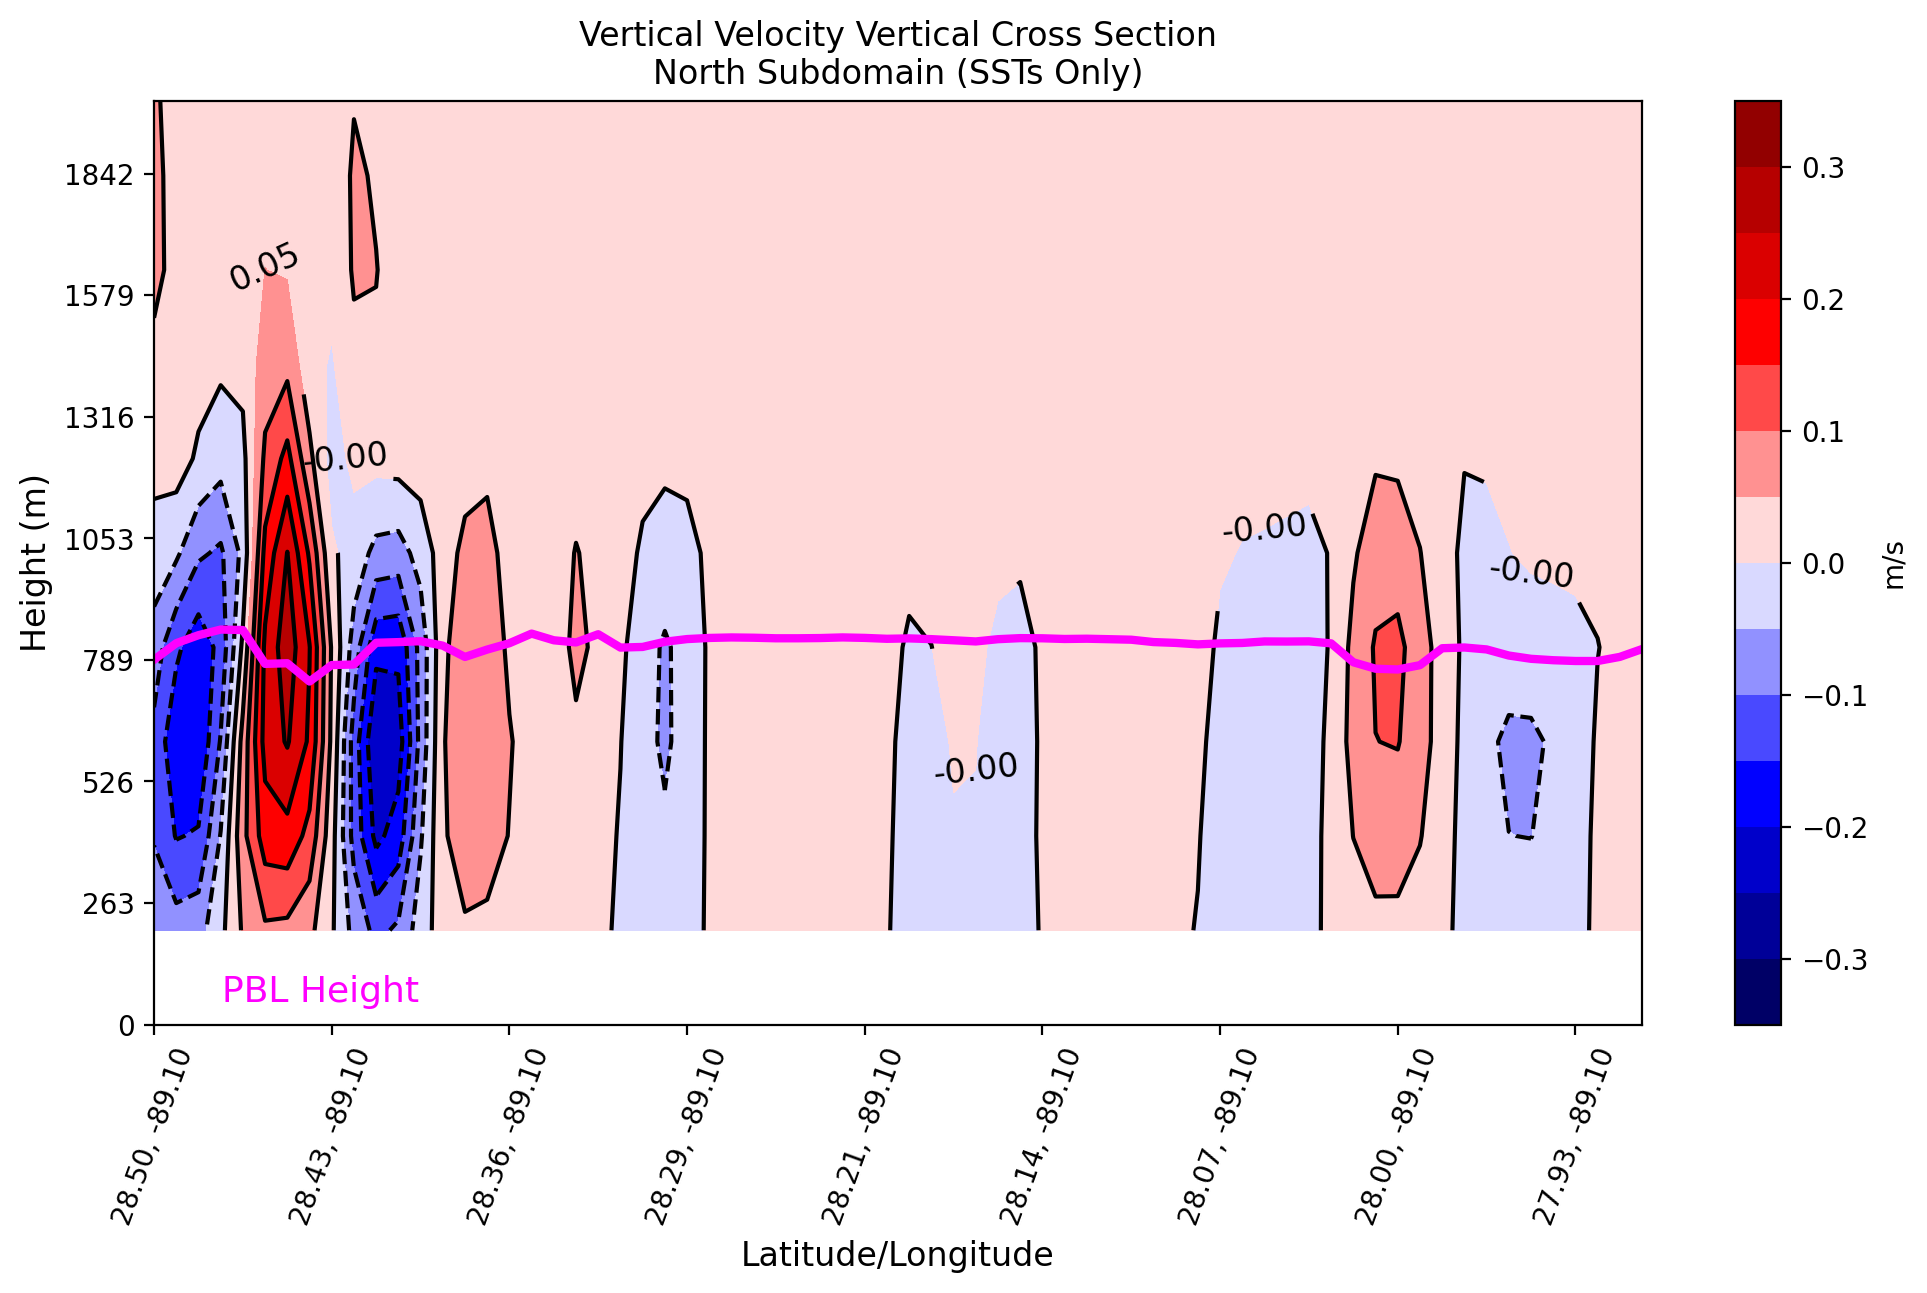

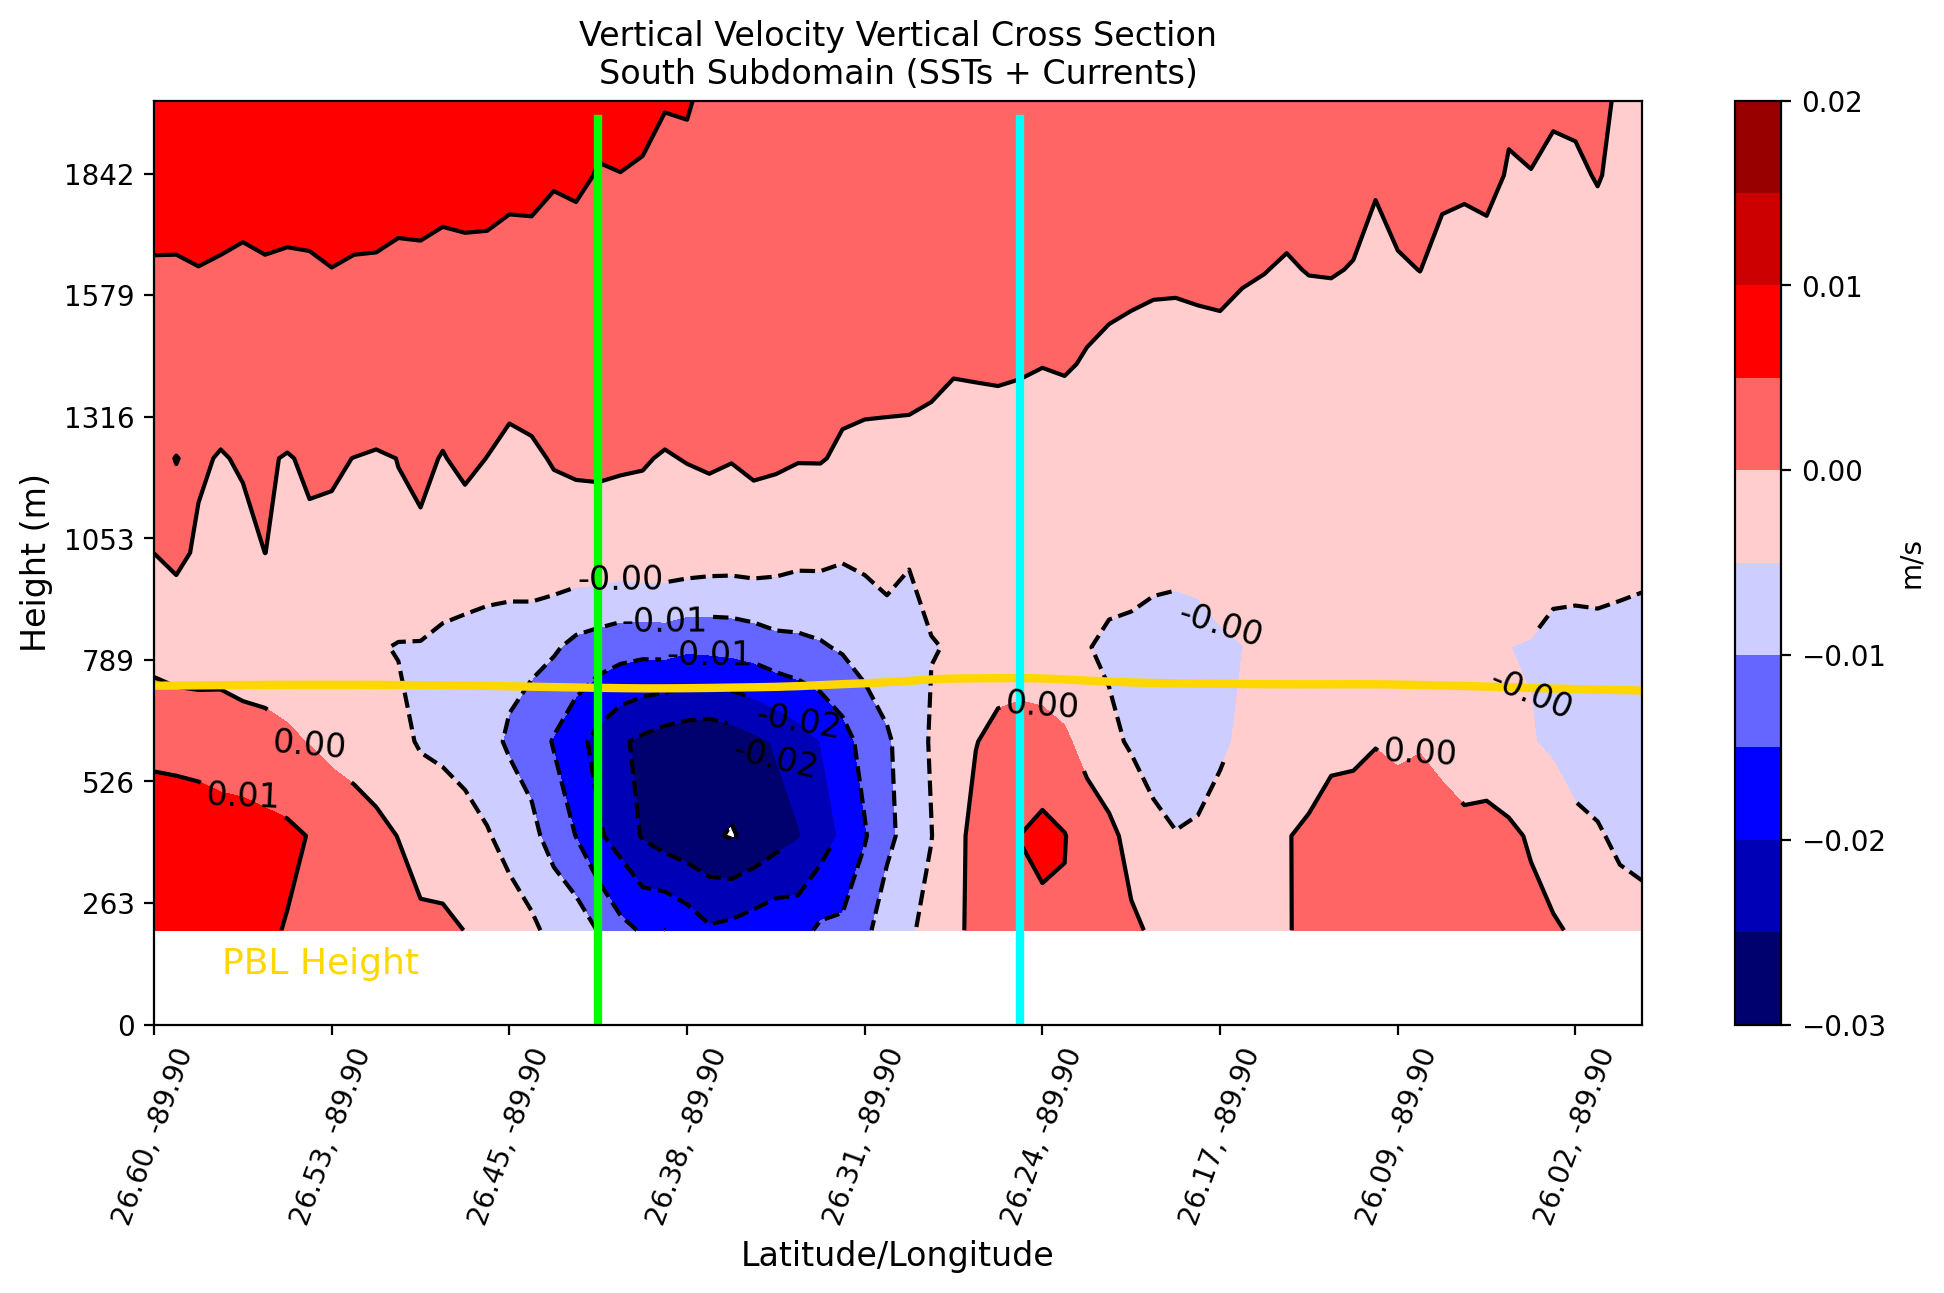

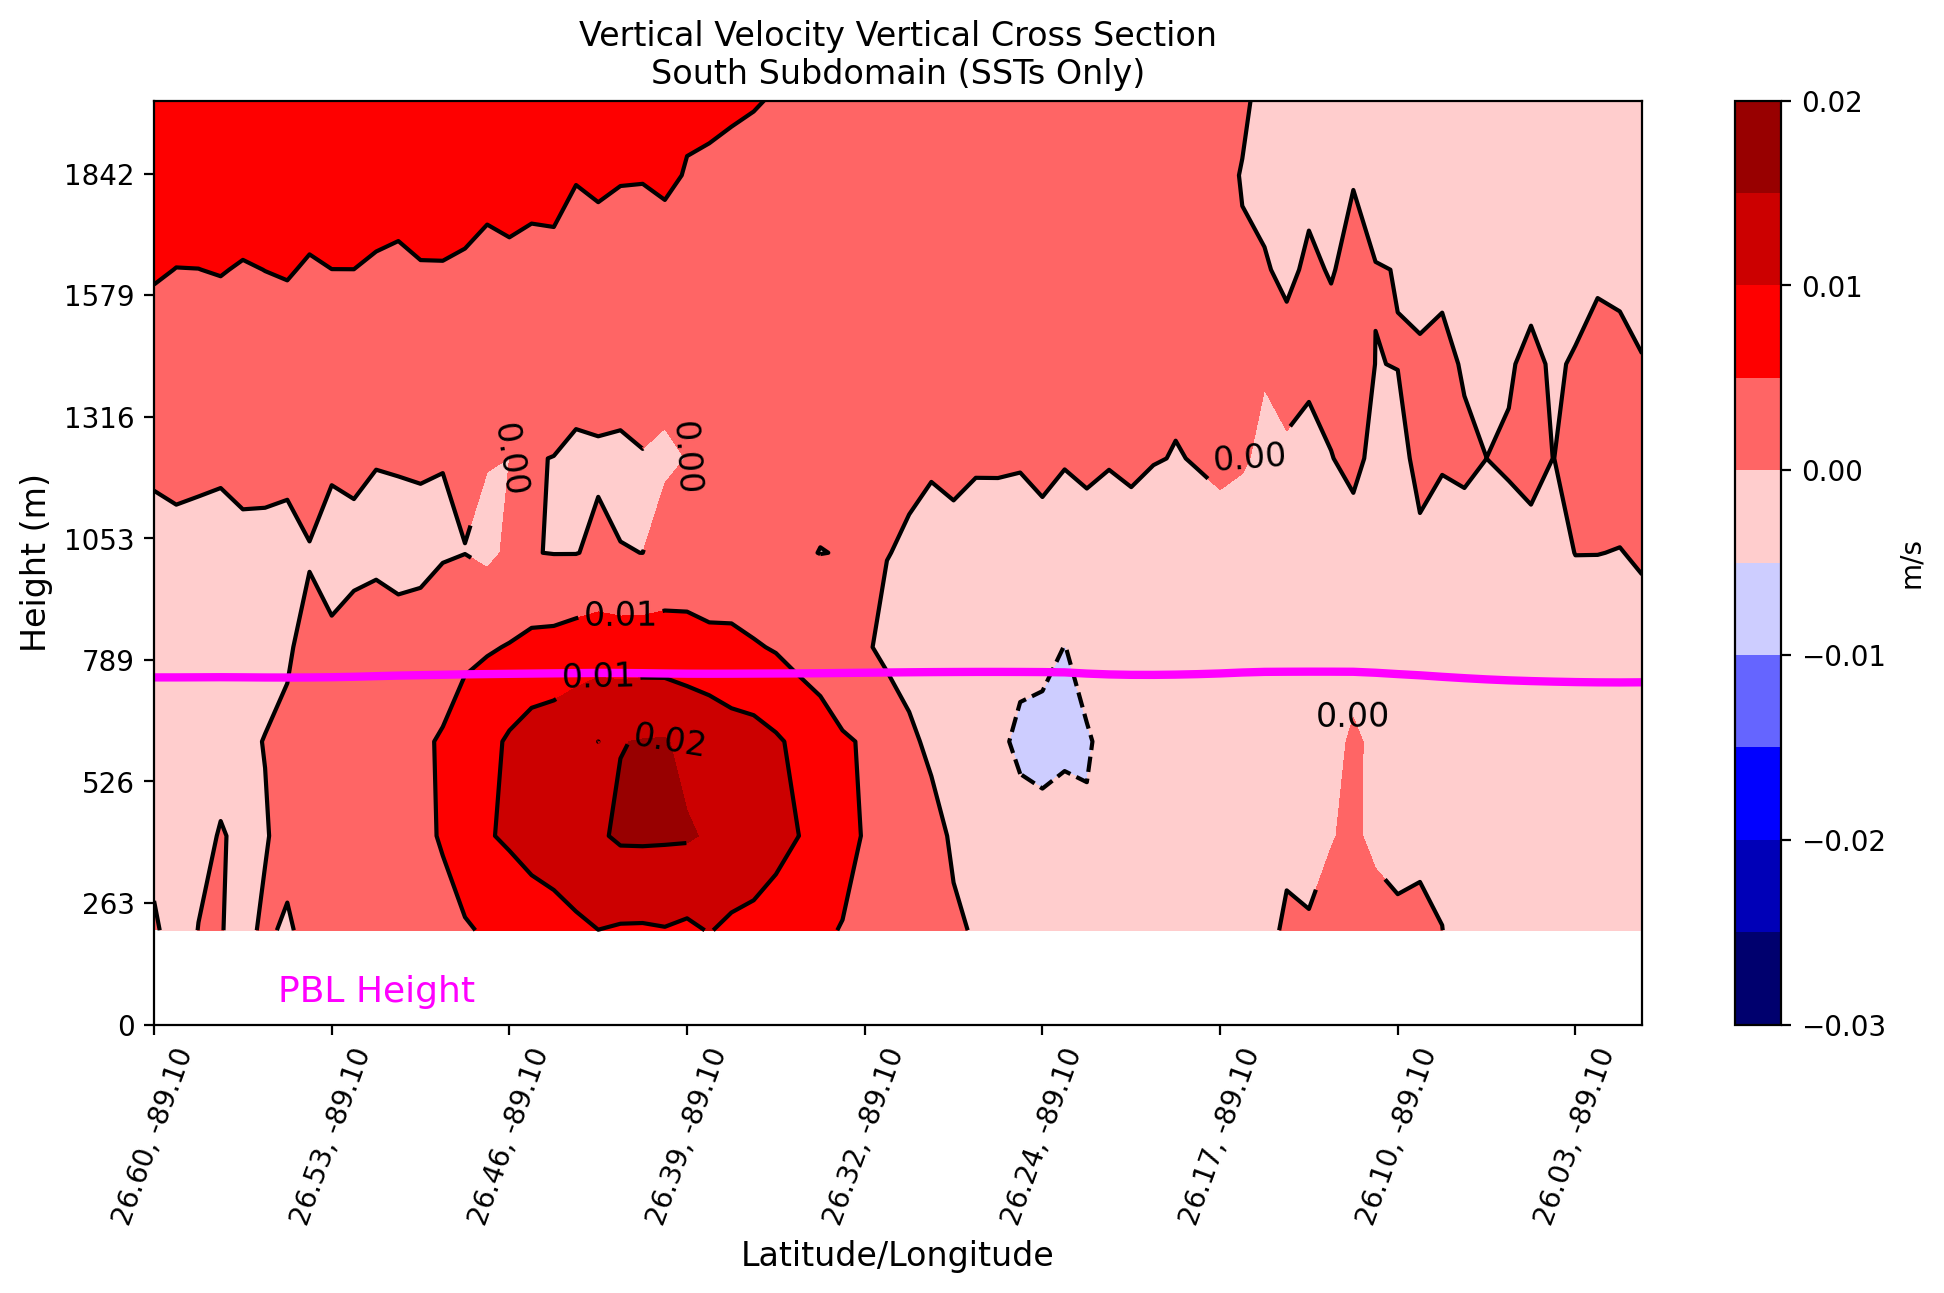

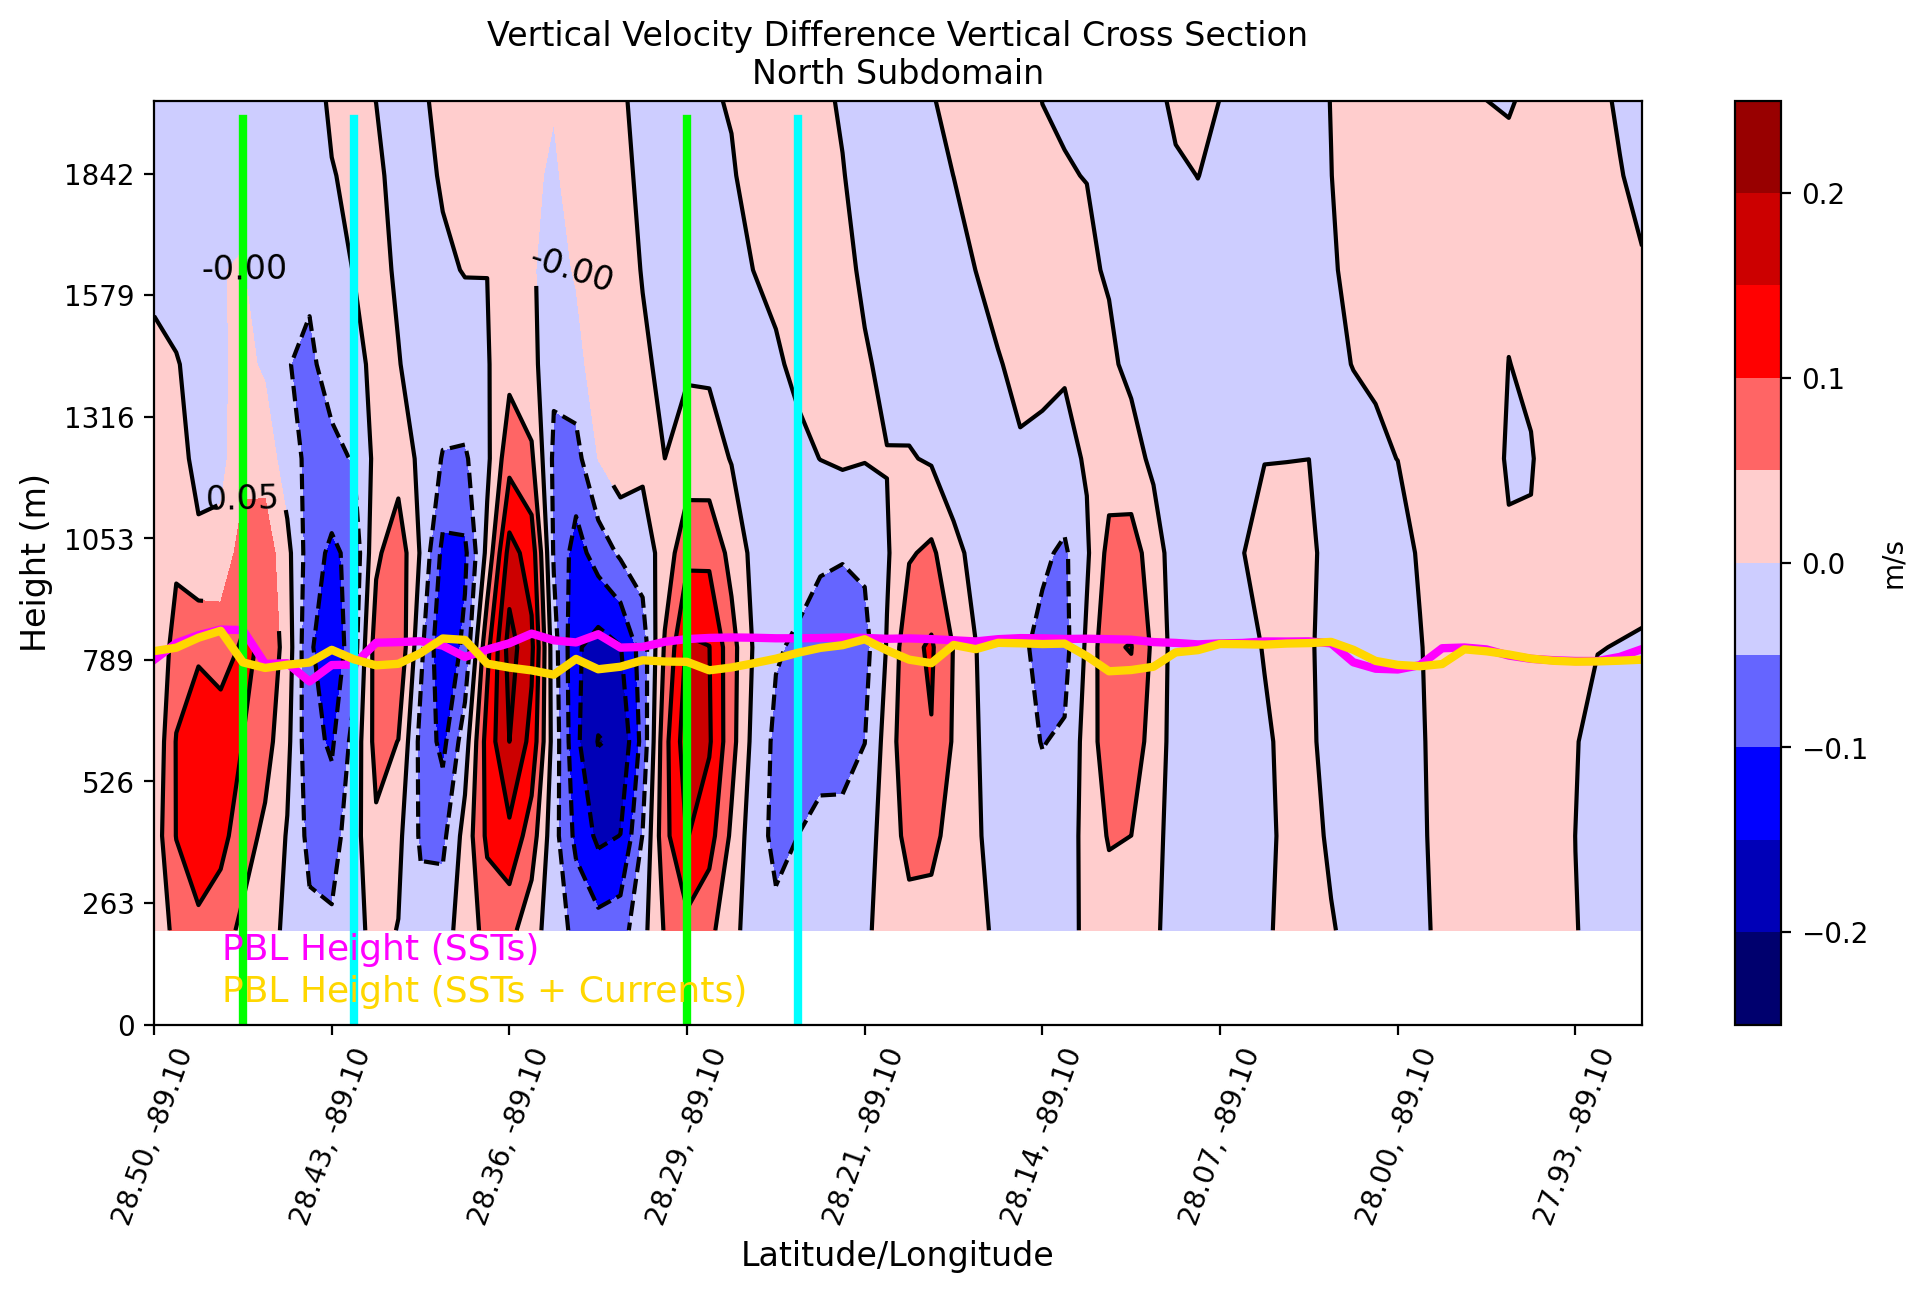

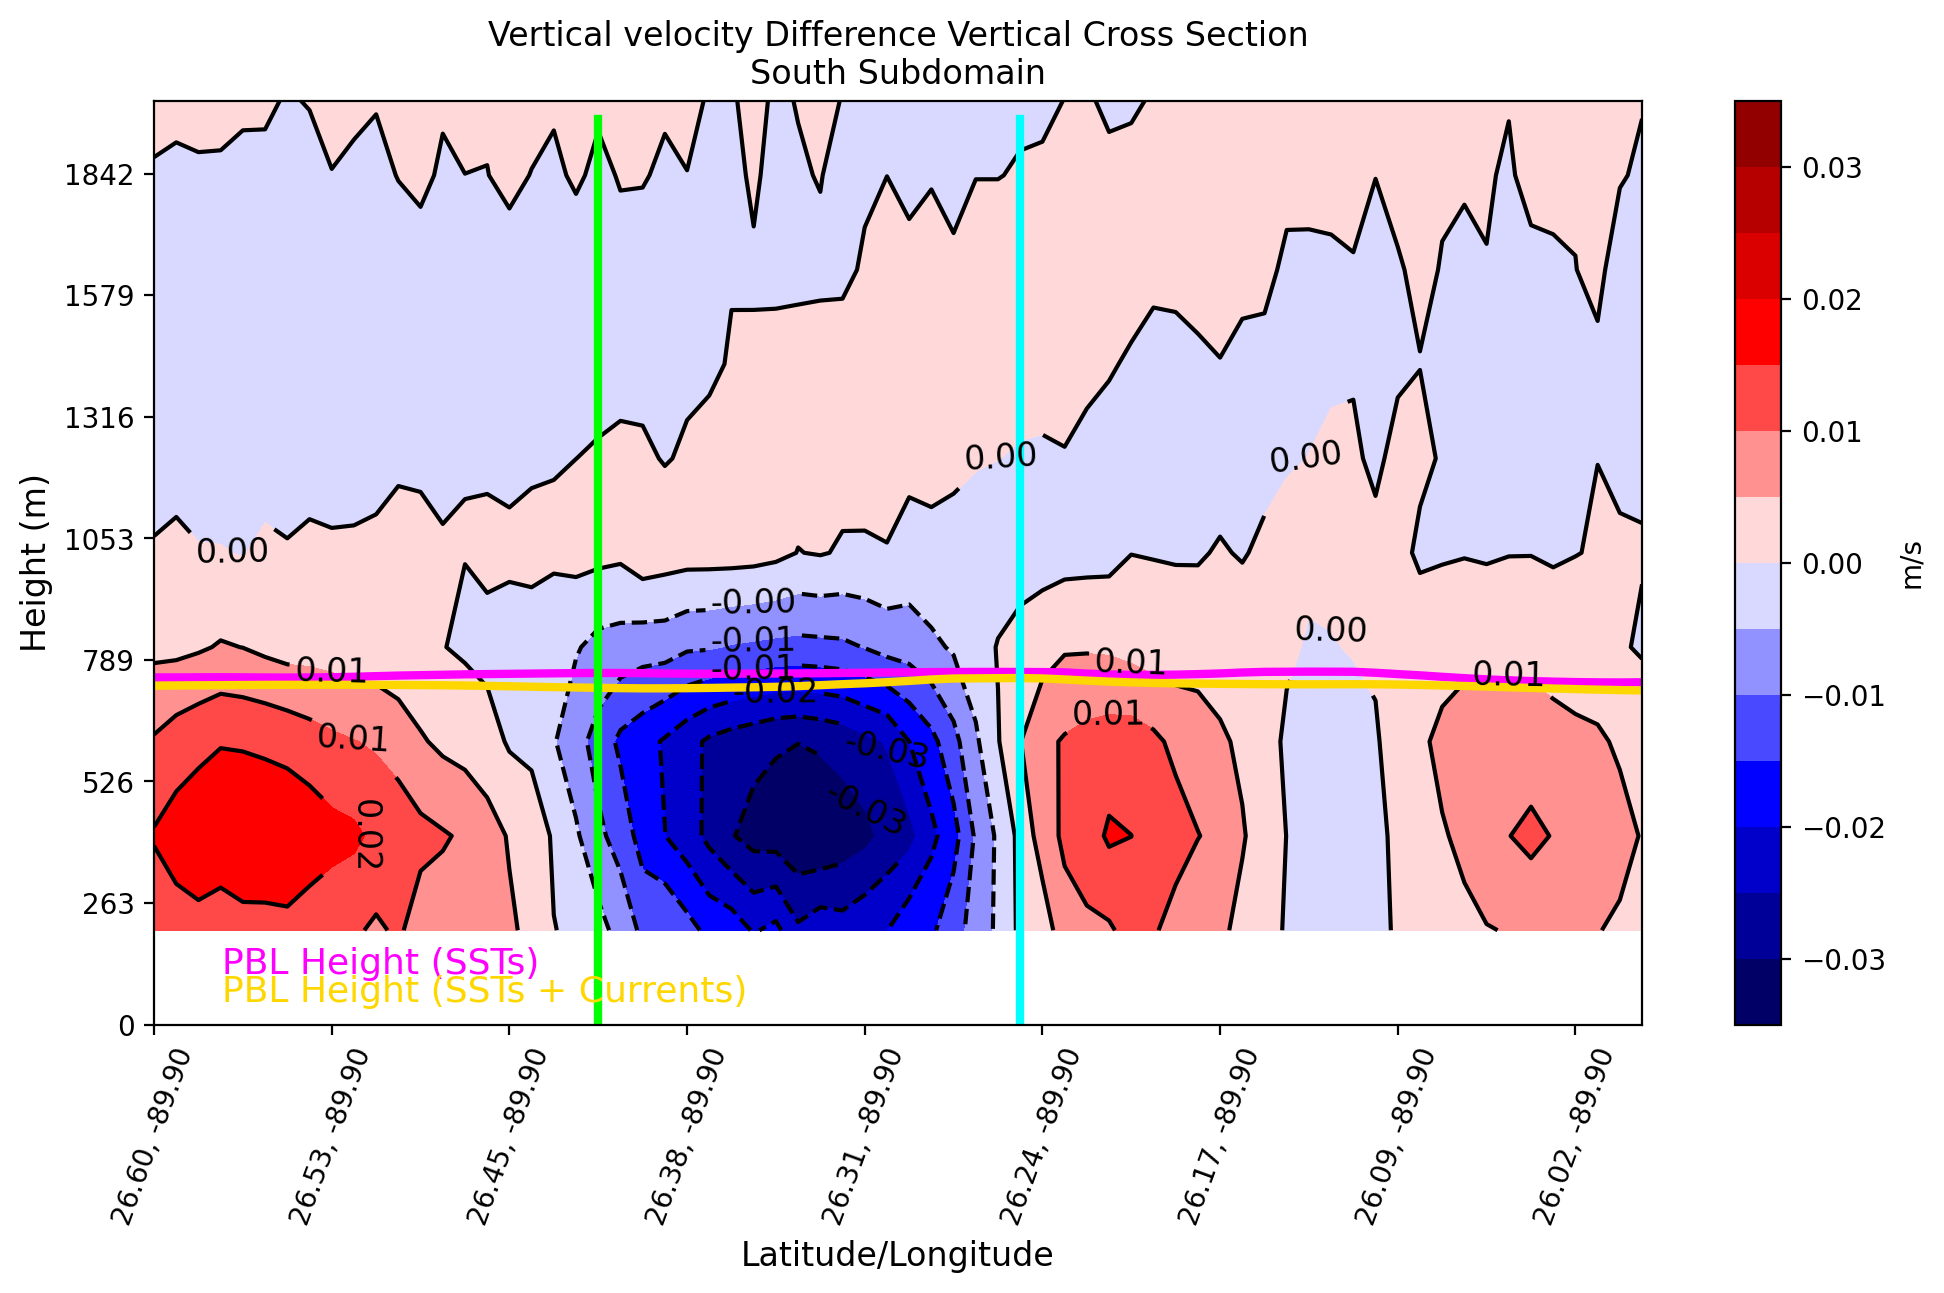

In [40]:
#HIGH POS OCEAN CURL LINES
#pos_lineN_A = 
#pos_lineN_B = 
#post_lineS =

#CUR NORTH
z = z_cur_north
theta = cur_w_north
pblh_line = N_pblh_line_cur
start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line

#print(x)
#print(y)
test_x = np.full((99), 9)
test_y = np.arange(0,1980,20)
test_x2 = np.full((99), 29)
test_y2 = np.arange(0,1980,20)
test_newX1 =np.full((99), 24)
test_newY1 = np.arange(0,1980,20)
test_newX2 = np.full((99), 4)
test_newY2 =np.arange(0,1980,20)

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35,0.4,0.05),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35,0.4,0.05), colors = 'black')
plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'gold' , linewidth=3)
plt.plot(test_x, test_y, color = 'cyan', linewidth=3)
plt.plot(test_x2, test_y2, color = 'cyan', linewidth=3)
plt.plot(test_newX1, test_newY1, color = 'lime', linewidth=3)
plt.plot(test_newX2, test_newY2, color = 'lime', linewidth=3)
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=13, color = 'gold')
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
#ax.set_xticks(x_ticks[::5])
#ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical Velocity Vertical Cross Section\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_wCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST NORTH
z = z_sst_north
theta = sst_w_north
pblh_line = N_pblh_line_sst
start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35,0.4,0.05),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35,0.4,0.05), colors = 'black')
plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'magenta', linewidth=3 )
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=13, color = 'magenta')
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical Velocity Vertical Cross Section\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_wCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#CUR SOUTH
z = z_cur_south
theta = cur_w_south
pblh_line = S_pblh_line_cur
start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line
test_xs = np.full((99), 39)
test_ys = np.arange(0,1980,20)
newX2 = np.full((99), 20)
newY2 =np.arange(0,1980,20)
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.03,0.025,0.005),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.03,0.025,0.005), colors = 'black')
plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'gold', linewidth=3 )
plt.plot(test_xs, test_ys, color = 'cyan' , linewidth=3)
plt.plot(newX2, newY2, color = 'lime', linewidth=3)
ax.annotate('PBL Height',xy=(80, 115), xycoords='figure points', fontsize=13, color = 'gold')
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical Velocity Vertical Cross Section\nSouth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_wCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#SST SOUTH
z = z_sst_south
theta = sst_w_south
pblh_line = S_pblh_line_sst
start_point = CoordPair(lat=26.6, lon=-89.1)
end_point = CoordPair(lat=26.0, lon=-89.1)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.03,0.025,0.005),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.03,0.025,0.005), colors = 'black')
plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'magenta' , linewidth=3)
ax.annotate('PBL Height',xy=(100, 105), xycoords='figure points', fontsize=13, color = 'magenta')
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical Velocity Vertical Cross Section\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_wCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#N DIFF
z = z_sst_north
theta = N_w_diff
pblh_line1 = N_pblh_line_cur
pblh_line2 = N_pblh_line_sst
start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line1
x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line2

test_x = np.full((99), 9)
test_y = np.arange(0,1980,20)
test_x2 = np.full((99), 29)
test_y2 = np.arange(0,1980,20)
test_newX1 =np.full((99), 24)
test_newY1 = np.arange(0,1980,20)
test_newX2 = np.full((99), 4)
test_newY2 =np.arange(0,1980,20)


theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.25,0.3,0.05),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.25,0.3,0.05), colors = 'black')
plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'magenta', linewidth=3 )
plt.plot(test_x, test_y, color = 'cyan', linewidth=3)
plt.plot(test_x2, test_y2, color = 'cyan', linewidth=3)
plt.plot(test_newX1, test_newY1, color = 'lime', linewidth=3)
plt.plot(test_newX2, test_newY2, color = 'lime', linewidth=3)

ax.annotate('PBL Height (SSTs)',xy=(80, 120), xycoords='figure points', fontsize=13, color = 'magenta')
plt.plot(x2, y2, color = 'gold' , linewidth=3)
ax.annotate('PBL Height (SSTs + Currents)',xy=(80, 105), xycoords='figure points', fontsize=13, color = 'gold')
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical Velocity Difference Vertical Cross Section\nNorth Subdomain")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'north_wCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#S DIFF
z = z_sst_south
theta = S_w_diff
pblh_line1 = S_pblh_line_cur
pblh_line2 = S_pblh_line_sst
start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line1
x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line2
newX2 = np.full((99), 20)
newY2 =np.arange(0,1980,20)
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           #to_np(theta_cross),np.arange(-0.1,0.1,0.02),cmap=get_cmap("viridis"))
                           to_np(theta_cross),np.arange(-0.035, 0.035, 0.005),cmap=get_cmap("seismic"))                             

plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.035, 0.035, 0.005), colors = 'black')
plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'magenta', linewidth=3 )
ax.annotate('PBL Height (SSTs)',xy=(80, 115), xycoords='figure points', fontsize=13, color = 'magenta')
plt.plot(x2, y2, color = 'gold' , linewidth=3)
ax.annotate('PBL Height (SSTs + Currents)',xy=(80, 105), xycoords='figure points', fontsize=13, color = 'gold')
plt.plot(test_xs, test_ys, color = 'cyan', linewidth=3 )
plt.plot(newX2, newY2, color = 'lime', linewidth=3)
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=70, fontsize=10)
#ax.set_xticks(x_ticks[::2])
#ax.set_xticklabels(x_labels[::2], rotation=70, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Vertical velocity Difference Vertical Cross Section\nSouth Subdomain")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/VertVel/'
plt.savefig(save_results_to + 'south_wCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

